#  BlueSTARR-predicted variant effects against benchmark(s)

We assess the accuracy of BlueSTARR model predictions by comparing its variant effect predictions against deltaSVM using experimental data from saturation mutagenesis via MPRA assays in [Kircher _et al_ (2019)](https://doi.org/10.1038/s41467-019-11526-w).

## Setup

### Imports

In [1]:
import pandas as pd
import duckdb
from pathlib import Path
import sys
sys.path.append('..')

### Paths to data and databases

In [2]:
PROJECT_ROOT = Path('/hpc/group/igvf')
DATA_ROOT = Path("../../igvf-pm")
DB_ROOT = PROJECT_ROOT / 'db'
MODELS = ['K562', 'A549-DMSO']
MUT_PRED_DBs = {k: DB_ROOT / f'Kircher-2019_{k}.parquet' for k in MODELS}
DATA_DIR = PROJECT_ROOT / 'benchmarks'
MPRA_DATA_DIR = DATA_DIR / 'Kircher_et_al_2019'
GKSVM_PREDS = DATA_DIR / 'MPRA-deltaSVM' / 'deltasvm_saturated_mutations.tsv'

## Kircher _et al_ (2019) MPRA data

In [3]:
from starrutil.mprautil import read_kircher_mpra_data
mpra_data = read_kircher_mpra_data(MPRA_DATA_DIR)

In [4]:
kircher_ntotal = len(mpra_data.select(['chrom']).collect())
kircher_nmut = len(mpra_data.select(['chrom', 'allele_pos', 'alt_allele']).unique().collect())
print(f"Total number of MPRA results: {kircher_ntotal:,}")
print(f"Total number of unique mutations: {kircher_nmut:,}")

Total number of MPRA results: 39,170
Total number of unique mutations: 29,444


## BlueSTARR mutation predictions

### Load BlueSTARR predictions for Kircher _et al_ 2019 regions

In [5]:
mutpreds = {}
for model, db in MUT_PRED_DBs.items():
    mutpreds[model] = duckdb.read_parquet(str(db))
    print(f"Predictions from {model}: {mutpreds[model].count('chrom').fetchall()[0][0]:,}")

Predictions from K562: 29,532
Predictions from A549-DMSO: 29,532


### Join with MPRA data

In [6]:
from starrutil.mprautil import join_preds_to_mpra

In [7]:
bk_dfs = {}
for model, mutdb in mutpreds.items():
    bk_dfs[model] = join_preds_to_mpra(mutdb, mpra_data, alt_col='allele')
    print(f"Number of MPRA results matched with BlueSTARR {model} predictions: {len(bk_dfs[model]):,} ({len(bk_dfs[model])/kircher_nmut:.1%})")

Number of MPRA results matched with BlueSTARR K562 predictions: 29,444 (100.0%)
Number of MPRA results matched with BlueSTARR A549-DMSO predictions: 29,444 (100.0%)


Sanity check: for every position, the reference alleles between Kircher _et al_ and BlueSTARR should be the same.

In [8]:
for model, bk_df in bk_dfs.items():
    ref_mismatched = bk_df.loc[bk_df['ref_allele'] != bk_df['pred_ref_allele']]
    print(f"Ref allele mismatches for {model}: {len(ref_mismatched):,}")

Ref allele mismatches for K562: 0
Ref allele mismatches for A549-DMSO: 0


## DeltaSVM mutation predictions

Load predictions, then join to MPRA data:

In [9]:
deltasvm_preds = pd.read_csv(GKSVM_PREDS, sep='\t', index_col=False)
deltasvm_df = join_preds_to_mpra(deltasvm_preds, mpra_data)
print(f"Number of MPRA results matched with DeltaSVM predictions: {len(deltasvm_df):,} ({len(deltasvm_df)/kircher_nmut:.1%})")

Number of MPRA results matched with DeltaSVM predictions: 29,444 (100.0%)


Sanity check for mismatched reference alleles:

In [10]:
ref_mismatched = deltasvm_df.loc[deltasvm_df['ref_allele'] != deltasvm_df['pred_ref_allele']]
print(f"Ref allele mismatches for DeltaSVM: {len(ref_mismatched):,}")

Ref allele mismatches for DeltaSVM: 0


## ROC display and AUC

### Define positive and negative classes

Kircher _et al_ (2019) calculate a p-value based on a linear regression model, and label positives (mutations having a significant effect) based on a p-value cut-off (p<1e-5). For the negative class (mutations without a significant effect) a cut-off on absolute effect size (at 0.05) is used. (Strictly speaking, Kircher _et al_ only give _"$log_2$ expression effect < 0.05"_, but we assume they meant _absolute_ expression effect.)

Additionally, labeling classes (as either a positive or a negative) requires a minimum Tag count. We use 10 as recommended in Kircher _et al_ (2019).

Kircher _et al_ (2019) don't explicitly mention whether there is a p-value cutoff as well for the negative class. We'll use the same value as for positives.

Note that this approach will leave some mutations unlabeled (those with low Tag count), which we drop.

In [11]:
from starrutil.mprautil import add_class_labels

In [12]:
Pval_pos = 1e-5
Pval_neg = 1e-5
effect_neg = 0.05
pos_label = f"MPRA p≤{Pval_pos}"
neg_label = f"MPRA p>{Pval_neg}"

In [13]:
bk_dfs = {
    model: add_class_labels(bk_df,
                            Pval_pos=Pval_pos,
                            Pval_neg=Pval_neg,
                            abs_effect_neg=effect_neg,
                            pos_label=pos_label, neg_label=neg_label).dropna(subset=['label'])
    for model, bk_df in bk_dfs.items()
}
bk_df = pd.concat(bk_dfs.values(), keys=bk_dfs.keys(), names=['model'])
bk_df.groupby(['model', 'region_type', 'label'])['chrom'].count()

model      region_type  label       
A549-DMSO  Enhancers    MPRA p>1e-05    7237
                        MPRA p≤1e-05    2770
           Promoters    MPRA p>1e-05    3418
                        MPRA p≤1e-05    1987
K562       Enhancers    MPRA p>1e-05    7237
                        MPRA p≤1e-05    2770
           Promoters    MPRA p>1e-05    3418
                        MPRA p≤1e-05    1987
Name: chrom, dtype: int64

In [14]:
deltasvm_df_roc = add_class_labels(
    deltasvm_df,
    Pval_pos=Pval_pos,
    Pval_neg=Pval_neg,
    abs_effect_neg=effect_neg,
    pos_label=pos_label, 
    neg_label=neg_label
).dropna(subset=['label'])
deltasvm_df_roc.groupby(['region_type','label'])['chrom'].count()

region_type  label       
Enhancers    MPRA p>1e-05    7237
             MPRA p≤1e-05    2770
Promoters    MPRA p>1e-05    3418
             MPRA p≤1e-05    1987
Name: chrom, dtype: int64

### ROC curve and AUROC

Kircher _et al_ in Supplementary Table 17-18 give AUC scores for a variety of classifiers, but in addition to the filtering (Tags >= 10; P≤1e-5 for TPs; P>1e-5 and $\log_2$(expression effect) < 0.05 for TNs) their ROC computation uses only the top _N_, with $N \in \{200, 500, 1000\}$, variants with "highest expression effect", which we assume to be the absolute expression effect size in $\log_2$ space.

We repeat this way of subsetting the data here, too.

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import RocCurveDisplay
from starrutil.roc import topN_dataset

In [16]:
def plot_rocs(bluestarr_df, deltasvm_df, pos_label):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    rocs_blue = {}
    rocs_deltasvm = {}
    for i, region_type in enumerate(['Enhancers', 'Promoters']):
        blue_df = bluestarr_df.loc[lambda df: df['region_type'] == region_type]
        gksvm_df = deltasvm_df.loc[lambda df: df['region_type'] == region_type]

        rocs_blue[region_type] = RocCurveDisplay.from_predictions(
            blue_df['label'], 
            blue_df['log2FC'].abs(), 
            name='BlueSTARR',
            pos_label=pos_label,
            ax=axs[i]
        )

        rocs_deltasvm[region_type] = RocCurveDisplay.from_predictions(
            gksvm_df['label'],
            gksvm_df['log2FC'].abs(), 
            name='DeltaSVM', 
            pos_label=pos_label,
            ax=axs[i],
            plot_chance_level=True,
            chance_level_kw={'linestyle': 'dotted', 'linewidth': 1.5, 'color': 'gray'}
        )
        axs[i].set_title(f'{region_type}')
    return fig, axs, (rocs_blue, rocs_deltasvm)

In [17]:
model = 'K562'
bluestarr_df = bk_df.xs(model, level='model')

##### AUROC plots: all data and top-N for $N\in \{1000, 500, 200\}$

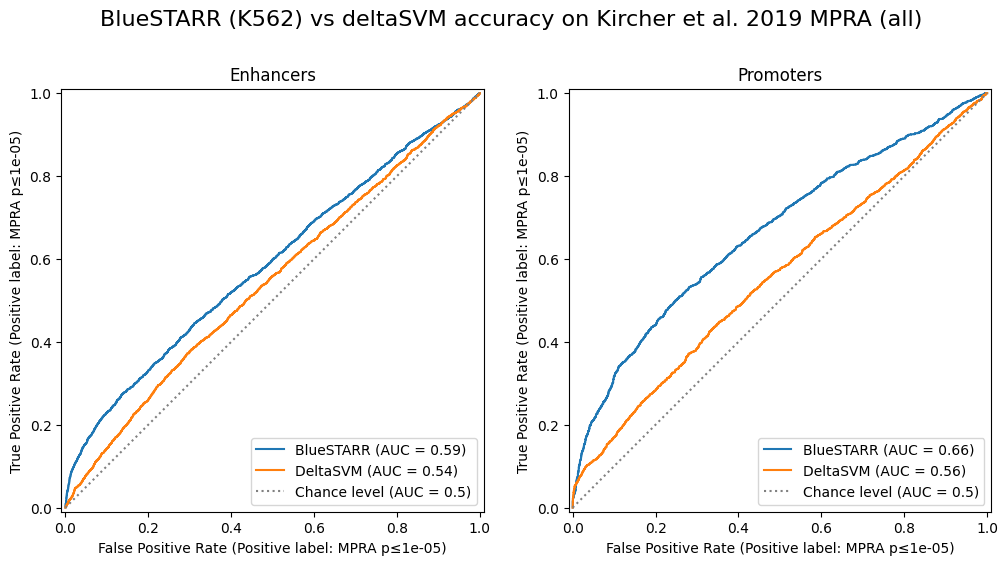

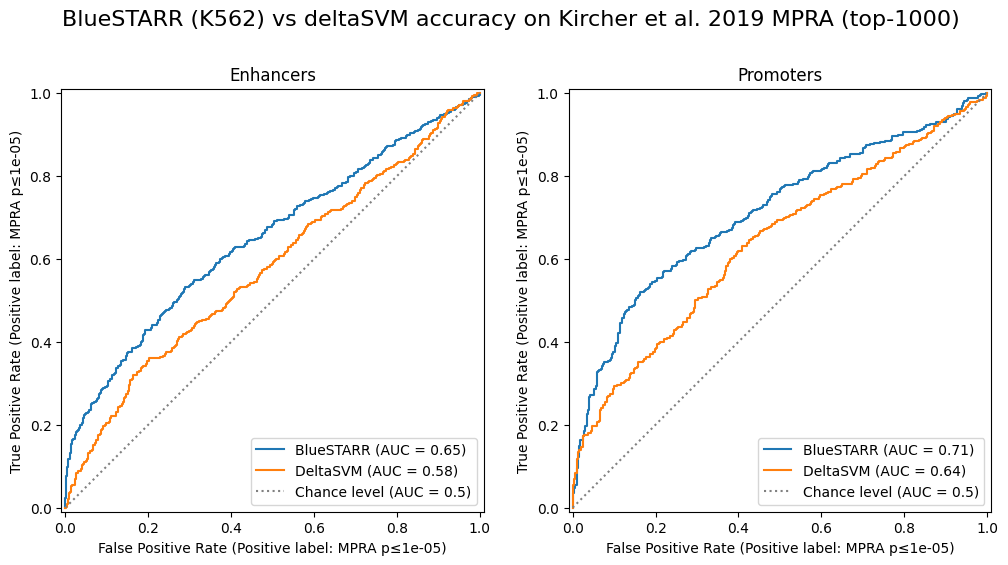

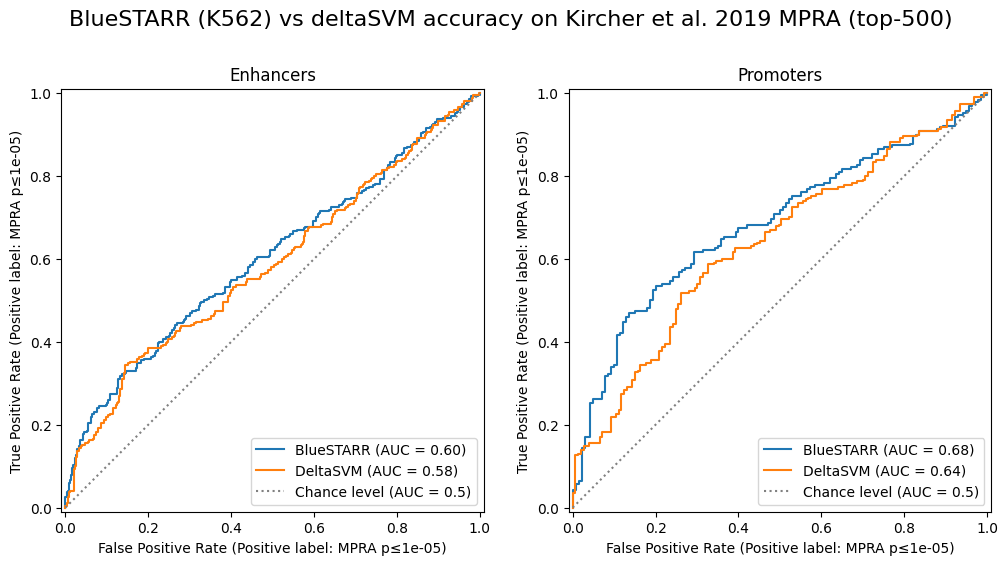

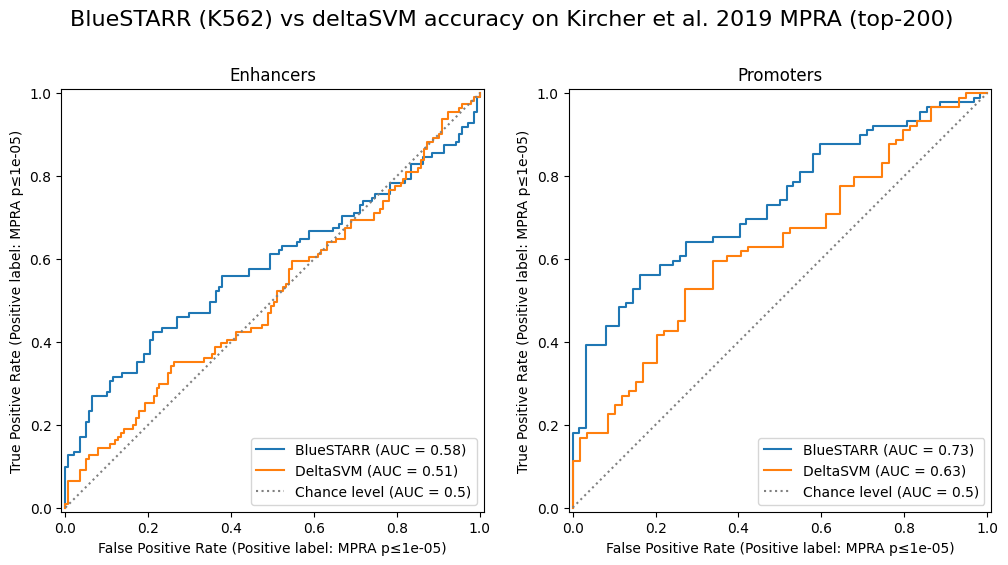

In [19]:
fig, axs, _ = plot_rocs(bluestarr_df, deltasvm_df_roc, pos_label)
_ = fig.suptitle(f'BlueSTARR ({model}) vs deltaSVM accuracy on Kircher et al. 2019 MPRA (all)', fontsize=16)

for N in [1000, 500, 200]:
    bluestarr_df_topN = topN_dataset(bluestarr_df, neg_label=neg_label, N=N)
    deltasvm_df_topN = topN_dataset(deltasvm_df_roc, neg_label=neg_label, N=N)
    fig, axs, _ = plot_rocs(bluestarr_df_topN, deltasvm_df_topN, pos_label)
    _ = fig.suptitle(f'BlueSTARR ({model}) vs deltaSVM accuracy on Kircher et al. 2019 MPRA (top-{N})', fontsize=16)